## Ice Temperature (icetemp) Package Tutorial

In [1]:
# Standard imports
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Imports from ice temperature estimation package
import icetemp
import icetemp.data_io as io
import icetemp.model as m

# Overview

This package is intended to infer the change in temperature at the surface of the Antarctic ice from measurements of temperature $(^\circ \text{C})$ as a function of depth (m) from thermistor data provided by the AMANDA and IceCube collaborations. Four data sets are provided between 2002 and 2010 (2002, 2007, 2009, and 2010) in [public data releases](https://icecube.wisc.edu/data-releases/2020/05/south-pole-ice-temperature/) by the collaborations. In order to obtain the temperature at the surface, we postulate a quadratic relationship between temperature and depth, and then extract the intercept (a linear relationship is also considered). Gaussian process regression is subsequently used on the inferred surface temperatures from different years to obtain a function which describes how the temperature has changed in the Antarctic over the aforementioned time period.   

This tutorial notebook details the generative model used to analyze the temperature data as a function of depth. The model involves uniform priors for each term of the polynomials studied and a normal likelihood to describe the Gaussian uncertainties on the temperature. These uncertaintes/sources of noise are directly related to the thermistor technical limitations. In this portion of the notebook, the generative models used to describe the dependence of temperature on depth are presented. In subsequent sections, the functions used to infer the paramaters of each model are demonstrated; one function performs least-squares fitting, while the other utilizes Markov chain Monte Carlo (MCMC) sampling. Finally, Gaussian process regression is used to infer the change in temperature at the surface of the Antarctic ice.

### Statistical Model
The generative model used to infer the ice warming assumes a polynomial dependence of the temperature as a function of depth.  The simplest form of the statistical model implemented requires a Gaussian likelihood for the temperature where the mean prediction is taken as the polynomial function. 
$$ T_i \sim \text{Normal}(\mu_i,\sigma_\text{T})$$ where $\sigma_T$ represents the temperature uncertainties and $\mu_i$ is our predictive polynomial model. For this study, different degree polynomials were considered defined by $\mu_i = C_0 + C_1 \cdot d + C_2 \cdot d^2 + ... + C_n \cdot d^n$ where d represents the depth measurements.
The priors for the model were constructed as uniform priors for all the polynomial coefficients. Thus, the uniform priors consist of an upper and lower bound, such that: 
$$ C_0 \sim \text{Uniform}(C_0^{\; lower},C_0^{\; upper})$$
$$ C_1 \sim \text{Uniform}(C_1^{\; lower},C_1^{\; upper})$$
$$ C_2 \sim \text{Uniform}(C_2^{\; lower},C_2^{\; upper})$$
$$ ... $$
These priors hold a linear relation with the measured data. They were determined by limited information of the experimental setup. It has been documented that the temperature at the ground level of the Ice Cube lab facilities during the austral summer period (i.e. November - February) is within the range of -45ºC to -55ºC, on average. Based on the temperature range, we defined the bounds for the polynomial intercept ($C_0$),  $$ C_0 \sim \text{Uniform}\Big(-55^{\circ}\text{C},-45^{\circ}\text{C}\Big).$$

For the remaining coefficients, they were analytically solved by stating that at the depth of 800 m (i.e. the start of the chain of thermistors and optical sensors of the detector) the expected temperatures do not exceed -60ºC to 10ºC, due to insulation in the ice. Thus, $$ C_n \sim \text{Uniform}\Big(\frac{-60}{800^n}\frac{^{\circ}\text{C}}{m^n},\frac{10}{800^n}\frac{^{\circ}\text{C}}{m^n}\Big).$$

The likelihood can be expressed as: 
$$ \mathcal{L} = \Big(\frac{1}{C_0^{u} - C_0^{l}}\Big) ... \Big(\frac{1}{C_n^{u} - C_n^{l}}\Big) \; \prod_i^N \frac{1}{\sqrt{2\pi\sigma_T^2}} 
\exp{\Bigg(\frac{- (T_i - (C_0 + C_1\cdot d_i + ...+ C_n \cdot d_i^n))^2}{2\sigma_T^2}\Bigg)}$$ where N is the number of data points.

**Let's take an in depth look at specific model such as linear and quadratic.**
___
## Linear dependence of temperature on depth

In the case of a linear relationship between temperature and depth, we have $ T = f(d) = C_0 + C_1 \cdot d $ where $d$ is the depth and $T$ is the temperature. For each of the true $T$ values with Gaussian uncertainties, the frequency distribution $p(T_i|d_i,\sigma_{Ti},C_0,C_1)$ for $T_i$ is 

$$ p(T_i|d_i,\sigma_T,C_0,C_1) = \frac{1}{\sqrt{2\pi \sigma_T^2}} \exp \Bigg(\frac{-(T_i - C_0 - C_1 \cdot d_i )^2}{2\sigma_T^2}\Bigg).$$

In our model, $\sigma_T$ represents the temperature uncertainties, and $C_0$ and $C_1$ are the coefficients of the linear fit.

Our statistical model is defined as follows:

$$ C_0  \sim \text{Uniform}( C_0^l, C_0^u) \rightarrow m \sim \text{Uniform}\Big(-55^{\circ}\text{C},-45^{\circ}\text{C}\Big)$$

$$ C_1 \sim \text{Uniform}( C_1^l, C_1^u) \rightarrow b \sim \text{Uniform}\Big(\frac{-60}{800}\frac{^{\circ}\text{C}}{m},\frac{10}{800}\frac{^{\circ}\text{C}}{m}\Big)$$ where we define $\mu_i = C_0 + C_1 \cdot d_i $

$$ T_i \sim \text{Normal}(\mu_i,\sigma_\text{T})$$

The likelihood for the set of parameters $(C_0, C_1)$ is given by: 
$$ \mathcal{L} \propto \prod_i \frac{1}{\sqrt{2\pi \sigma_T^2}} \exp \Bigg(\frac{-(y_i - C_0 - C_1 x_i)^2}{2\sigma_T^2}\Bigg) $$ where $y_i$ and $x_i$ are data points for temperature and depth, respectively.
___
## Quadratic dependence of temperature on depth
In the case of a quadratic relationship between temperature and depth, we have $ T = f(d) = C_0 + C_1 \cdot d + C_2 \cdot d^2 $ where $d$ is the depth and $T$ is the temperature. For each of the true $T$ values with Gaussian uncertainties, the frequency distribution $p(T_i|d_i,\sigma_{Ti},C_0, C_1, C_2)$ for $T_i$ is 

$$ p(T_i|d_i,\sigma_{T},C_0, C_1, C_2) = \frac{1}{\sqrt{2\pi \sigma_T^2}} \exp \Bigg(\frac{-(T_i - C_0 + C_1 \cdot d_i + C_2 \cdot d_i^2)^2}{2\sigma_T^2}\Bigg).$$

In our model, $\sigma_T$ represents the temperature uncertainties, and $C_0, C_1, C_2$ are the coefficients of the quadratic fit.

Our statistical model is defined as follows:

$$ C_0  \sim \text{Uniform}( C_0^l, C_0^u) \rightarrow m \sim \text{Uniform}\Big(-55^{\circ}\text{C},-45^{\circ}\text{C}\Big)$$

$$ C_1 \sim \text{Uniform}( C_1^l, C_1^u) \rightarrow b \sim \text{Uniform}\Big(\frac{-60}{800}\frac{^{\circ}\text{C}}{m},\frac{10}{800}\frac{^{\circ}\text{C}}{m}\Big)$$ 

$$ C_2 \sim \text{Uniform}( C_2^l, C_2^u) \rightarrow b \sim \text{Uniform}\Big(\frac{-60}{800^2}\frac{^{\circ}\text{C}}{m^2},\frac{10}{800^2}\frac{^{\circ}\text{C}}{m^2}\Big)$$ where we define $\mu_i = C_0 + C_1 \cdot d_i + C_2 \cdot d_i^2$

$$ T_i \sim \text{Normal}(\mu_i,\sigma_\text{T})$$

The likelihood for the set of parameters ($C_0, C_1, C_2$) is given by: 
$$ \mathcal{L} \propto \prod_i \frac{1}{\sqrt{2\pi \sigma_T^2}} \exp \Bigg(\frac{-(y_i - C_0 -C_1 x_i - C_2 x_i^2 )^2}{2\sigma_T^2}\Bigg) $$ where $y_i$ and $x_i$ are data points for temperature and depth, respectively.
___
___

## Let's take a look at our data!

The function `load_ice_data()` in `data_io.py` returns a Pandas DataFrame which encapsulates the data and metadata associated with a specific data set. Temperature measurements $(^\circ \text{C})$, depth measurements (m), year of data taking, temperature uncertainty ($\sigma_T = 0.1 ^\circ \text{C}$), and depth uncertainty ($\sigma_d = 2$ m) are all included.

In [2]:
# load some (real) data
ex_data = io.load_ice_data("icecube_temp.2007.txt", data_year=2007,temp_errors=0.1, depth_errors=2)
print(ex_data)

    Temperature    Depth  data_year  temp_errors  depth_errors
0        -28.76  2078.18       2007          0.1             2
1        -25.09  2214.35       2007          0.1             2
2        -20.93  2350.52       2007          0.1             2
3        -26.51  2161.09       2007          0.1             2
4        -22.42  2297.25       2007          0.1             2
5        -17.89  2433.42       2007          0.1             2
6        -25.79  2195.40       2007          0.1             2
7        -21.55  2331.57       2007          0.1             2
8        -18.23  2433.69       2007          0.1             2
9        -26.26  2171.54       2007          0.1             2
10       -17.69  2443.87       2007          0.1             2


Using the DataFrame, we can calculate the likelihood function of our statistical model given a specific set of parameters. Below, the likelihood is calculated for some linear and quadratic test data. The details of how this test data was generated are provided in the `test_data` directory. 

The likelihood value for the linear model with the test data is 5.35e+09
The likelihood value for the quadrartc model with the test data is 2.16e+07


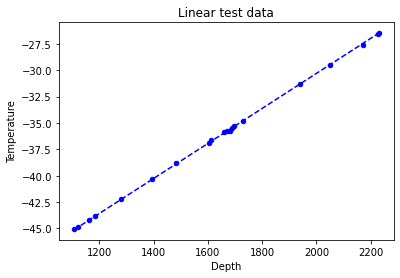

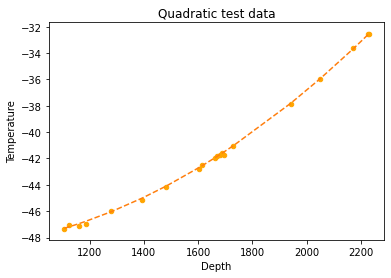

In [3]:
# defining model parameters for linear and quadratic fit (same values used to generate test data)
a0_lin, a1_lin = -6.35e1, 1.66e-2
a0_quad, a1_quad, a2_quad = -4.66e1, -7.47e-3, 6.18e-6

# linear test data
test_linear = io.load_ice_data("test_data_linear.txt", data_year=0, temp_errors=0.1, depth_errors=2, data_dir='test_data')
test_linear.plot(x='Depth', y='Temperature', kind='scatter', yerr=test_linear['temp_errors'], color='blue')
x = test_linear['Depth'].values
print('The likelihood value for the linear model with the test data is {:.2e}'.format(m.calc_linear_likelihood(test_linear, a0_lin, a1_lin)))
x.sort()
plt.plot(x, a1_lin*x + a0_lin, color='blue', linestyle='dashed')
plt.title("Linear test data")

# quadratic test data
test_quad = io.load_ice_data("test_data_quadratic.txt", data_year=0, temp_errors=0.1, depth_errors=2, data_dir='test_data')
test_quad.plot(x='Depth', y='Temperature', kind='scatter', yerr=test_quad['temp_errors'],color='orange')
plt.plot(x, a2_quad*x**2 + a1_quad*x + a0_quad, linestyle='dashed')
plt.title("Quadratic test data")
print('The likelihood value for the quadrartc model with the test data is {:.2e}'.format(m.calc_quad_likelihood(test_quad, a0_quad, a1_quad, a2_quad)))

## Doing some inference on the test data (quadratic fit)

The function `fit_quad()` in `model.py` fits the data to a quadratic function using least-squares regression and extracts the relevant parameters and covariance matrix. Let's do some inference on the quadratic test data and see if our parameters agree to a reasonable extent. In this function, only the errors on the temperature are considered. 

Values used to generate data:
b = -46.6
m = -0.00747
q = 6.18e-06

Best fit values:
b = -46.3 ± 0.479
m = -0.00791 ± 0.000592
q = 6.33e-06 ± 1.77e-07


Text(0.5, 1.0, 'Quadratic test data with quadratic fit (parameters inferred)')

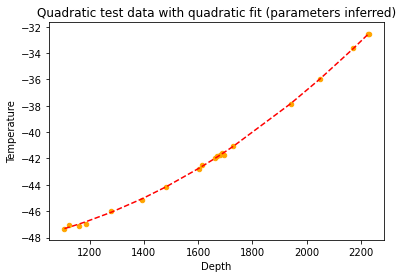

In [4]:
params, cov_mat = m.fit_quad(test_quad)
param_errors = np.sqrt(np.diag(cov_mat))  

print("Values used to generate data:")
print("b = {:.3}".format(a0_quad))
print("m = {:.3}".format(a1_quad))
print("q = {:.3}".format(a2_quad))

# print formatting function adapted from HW 6 solutions
print("\nBest fit values:")
for value, sigma, name in zip(params, param_errors, 'bmq'):
    print('{} = {:.3} ± {:.3}'.format(name, value, sigma))

test_quad.plot(x='Depth', y='Temperature', kind='scatter', yerr=test_quad['temp_errors'],color='orange')
plt.plot(x, params[2]*x**2 + params[1]*x + params[0], linestyle='dashed', color='red')
plt.title("Quadratic test data with quadratic fit (parameters inferred)")

Indeed, this simple inference returns the parameters with which we generated the test data within the errors.

## Inference on test data with MCMC (quadratic fit)

Also in `model.py` is the function `fit_quad_MCMC()`, which fits the data to a quadratic function and extracts the relevant parameters and covariance matrix, this time using `pymc3`, which utilizes MCMC sampling techniques. We previously defined our priors as Flat because no previous information about warning is considered. Again, only the errors on the temperature are considered.

/usr/local/lib/python3.9/site-packages/pymc3/sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [C_2, C_1, C_0]


Sampling 4 chains for 1_500 tune and 2_500 draw iterations (6_000 + 10_000 draws total) took 36 seconds.
The acceptance probability does not match the target. It is 0.7181173672683749, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
/usr/local/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/usr/local/lib/pyt

[-4.63101427e+01 -7.92176600e-03  6.33000000e-06]


Text(0.5, 1.0, 'Quadratic test data with quadratic fit (parameters from MCMC)')

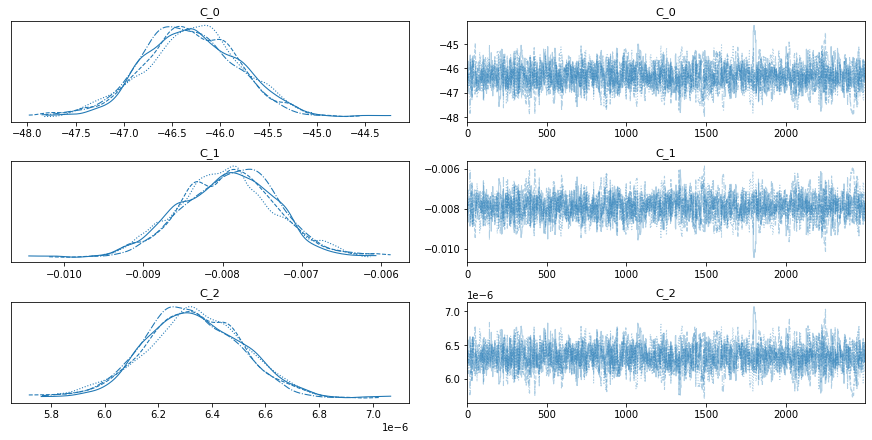

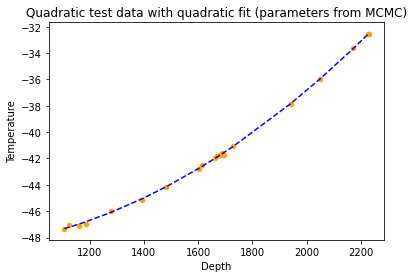

In [5]:
init_guess = {'C_0':-50, 'C_1':0.00, 'C_2':0.00}
traces = m.fit_quad_MCMC(test_quad, init_guess) # returns params (and their errors) in order C_0, C_1, C_2

#using helper function to extract params and param errors from traces
params, param_errors = m.get_params(2, traces, input_traces = True)
print(params)

test_quad.plot(x='Depth', y='Temperature', kind='scatter', yerr=test_quad['temp_errors'],color='orange')
plt.plot(x, params[2]*x**2 + params[1]*x + params[0], linestyle='dashed', color='blue')
plt.title("Quadratic test data with quadratic fit (parameters from MCMC)")

Once again, the values obtained agree nicely with the values used to generate the test data.

## Doing some inference on the real data
Now that we know `fit_quad()` works with the test data, we can perform some inference on the real data from different years and extract the model parameters when we postulate a quadratic dependence between temperature and depth. For the purpose of keeping the tutorial notebook brief, only one data set (2002) is analyzed. 


Best fit values for real data of 2002:
b = -46.2 ± 2.01
m = -0.00849 ± 0.00257
q = 8.07e-06 ± 8.09e-07


Text(0.5, 1.0, 'Real data with quadratic fit (parameters inferred) for 2002')

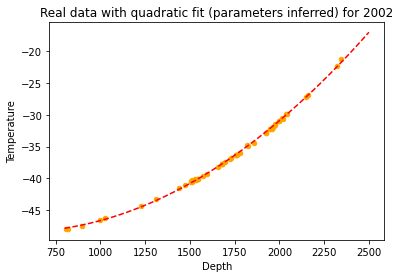

In [14]:
# load real data
data_2002 = io.load_ice_data("amanda_temp.txt", data_year=2002, temp_errors=1., depth_errors=2)
# most functions takes a list of dataframes as input
data = [data_2002]

# define fit range
x = np.linspace(800,2500)

params, cov_mat = m.fit_quad(data_2002)
#get stdev of parameters from covariance matrix
param_errors = np.sqrt(np.diag(cov_mat))

# print formatting function adapted from HW 6 solutions
print("\nBest fit values for real data of {}:".format(data_2002['data_year'][0]))
for value, sigma, name in zip(params, param_errors, 'bmq'):    # doesn't return params_errors 
    print('{} = {:.3} ± {:.3}'.format(name, value, sigma))

x.sort()    
data_2002.plot(x='Depth', y='Temperature', kind='scatter', yerr=0.1,color='orange')
plt.plot(x, params[2]*x**2 + params[1]*x + params[0], linestyle='dashed', color='red')
plt.title("Real data with quadratic fit (parameters inferred) for {}".format(data_2002['data_year'][0]))

## Inference on real data with MCMC

Using `fit_quad_MCMC()`, we infer the paramaters of our model on real data by performing MCMC sampling. As before, only the errors on the temperature are considered. We have adopted the initial guess to be similar to our previous results for polynomial fitting.

/usr/local/lib/python3.9/site-packages/pymc3/sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [C_2, C_1, C_0]


Sampling 4 chains for 1_500 tune and 2_500 draw iterations (6_000 + 10_000 draws total) took 26 seconds.
There were 431 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5297426030618684, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8822889271482394, but should be close to 0.8. Try to increase the number of tuning steps.
There were 419 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6051807939512149, but should be close to 0.8. Try to increase the number of tuning steps.
There were 341 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.42166720746981445, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger th

Paremters from MCMC for the year 2002


/usr/local/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/usr/local/lib/python3

[-4.53644837e+01 -9.59104000e-03  8.40700000e-06]


Text(0.5, 1.0, 'Real data with quadratic fit (parameters from MCMC) for 2002')

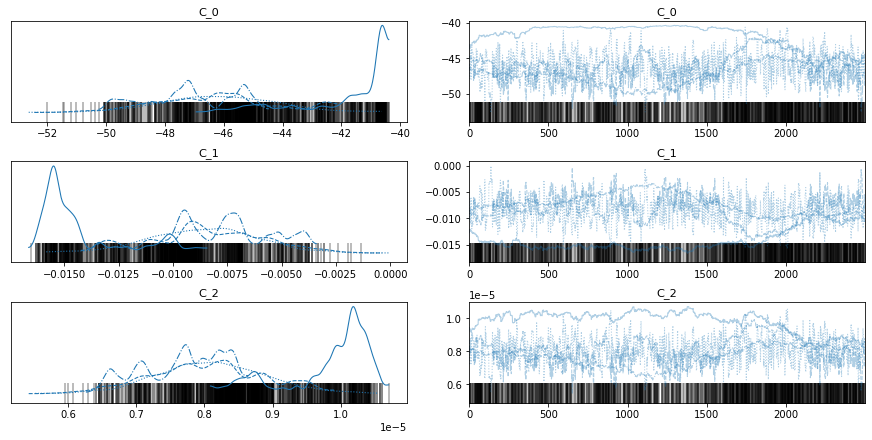

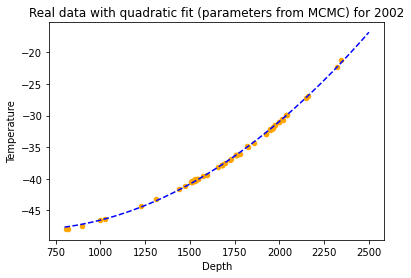

In [7]:
init_guess = {'C_0':-50, 'C_1':0.00, 'C_2':0.00}

traces = m.fit_quad_MCMC(data_2002, init_guess) # returns params in order b, m, q
print("Paremters from MCMC for the year {}".format(data_2002['data_year'][0]))

#using helper function to extract params and param errors from traces
params, param_errors = m.get_params(2, traces, input_traces = True)
print(params)

data_2002.plot(x='Depth', y='Temperature', kind='scatter', yerr=0.1,color='orange')
plt.plot(x, params[2]*x**2 + params[1]*x + params[0], linestyle='dashed', color='blue')
plt.title("Real data with quadratic fit (parameters from MCMC) for {}".format(data_2002['data_year'][0]))

____
Instead of limiting our package to just fitting the data to a quadratic function, we have generalized our fitting function for any polynomial to the nth power. Using `n_polyfit_MCMC()`, we infer the paramaters of our model on real data by performing MCMC sampling. As before, only the errors on the temperature are considered. We have adopted the initial guess to be similar to our previous results for polynomial fitting.

Below, `n_polyfit_MCMC()` is demonstraited with `n = 2` and `n = 3`. Indeed, we are able to fit the quadratic to our data!


Paremters from MCMC for the year 2002
[-4.62036336e+01 -8.49354960e-03  8.06586636e-06]


,year,temperature,prediction_errors
0,2002,-46.203634,0.916759


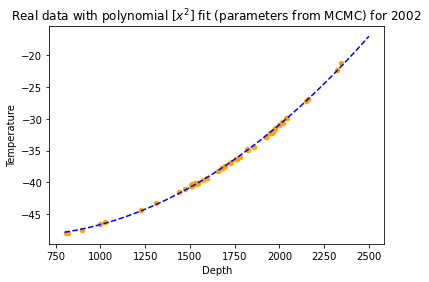

In [8]:
data_2002 = io.load_ice_data("amanda_temp.txt", data_year=2002, temp_errors=1., depth_errors=2)

# most functions takes a list of dataframes as input
data = [data_2002]
n = 2
init_guess1 = [{'C_0':-52, 'C_1':-0.0009, 'C_2':8.07e-06}] #based on the results from the algebraic fit of all datasets (see above)
best_fit_list1 = []
best_fit_errors_list1 = []
for year in range(len(data)):
        traces, best_fit1 = m.n_polyfit_MCMC(n, data[year], init_guess1[year]) # returns params in order C_0, C_1, C_2,...
        params, errors = m.get_params(n, best_fit1)
        best_fit_list1.append(params)
        best_fit_errors_list1.append(errors)
# plot fit
m.plot_polyfit(data, best_fit_list1)
# get timetable
m.get_timetable(data, best_fit_list1, best_fit_errors_list1)


Paremters from MCMC for the year 2002
[-5.20897301e+01  4.14277630e-03 -4.01429619e-07  1.79973663e-09]


,year,temperature,prediction_errors
0,2002,-52.08973,1.196887


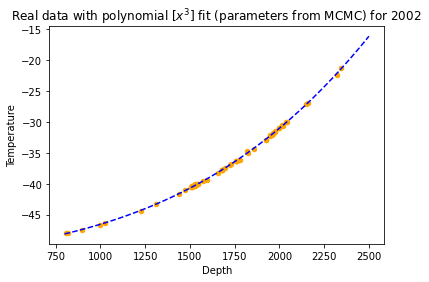

In [9]:
n = 3
init_guess2 = [{'C_0':-56, 'C_1':-0.0009, 'C_2':8.07e-06, 'C_3':0.00}] #based on the results from the algebraic fit of all datasets (see above)
best_fit_list2 = []
best_fit_errors_list2 = []
for year in range(len(data)):
        traces, best_fit2 = m.n_polyfit_MCMC(n, data[year], init_guess2[year]) # returns params in order C_0, C_1, C_2,...
        params, errors= m.get_params(n, best_fit2)
        best_fit_list2.append(params)
        best_fit_errors_list2.append(errors)
# plot fit
m.plot_polyfit(data, best_fit_list2)
# get timetable
m.get_timetable(data, best_fit_list2, best_fit_errors_list2)

Now that we have a function for any order polynomial we can compare to see which model best fits the data by calculating odds ratios. The function `get_odds_ratio()` allows us to compare between a polynomial of order $n_1$ and a polynomial of order $n_2$.  


Let's consider a 2nd order and a 3rd order polynomial, and calculate the odds ratio.

In [10]:
n_M1 = 2
n_M2 = 3

odds_ratio_list = m.get_odds_ratio(n_M1, n_M2, data, best_fit1, best_fit2)
print('The odds ratio is', odds_ratio_list[0])

Likelihood 1:  1.5106557103084764e-24
Likelihood 2:  2.176840666513331e-24
The odds ratio is 1.4014852229630004e-05


___
___

# Incorporating data sets taken at different years to infer changes in surface temperature

As stated in the Overview, the overall goal of this package is to infer the temperature of the Antarctic surface at any given year based on ice temperature data collected between 2002 and 2010. From the thermistor data, we only receive data for temperature and depth, as shown in the figure below. The uncertaintes/noise sources are directly related to the thermistor technical limitations.

![Experimental Data](https://github.com/phys201/icetemp/blob/main/icetemp/south_pole_ice_temperature_data_release/south_pole_ice_temperature.png?raw=true)

This package uses  **Gaussian process regression (GPR)**  to estimate the temperature at ground level at any given time (year) with the approproate uncertainties. Gaussian processes are fully compatible with Bayesian inference. We will calculate the uncertainties from the posterior distribution obtained from inferring the temperature at the surface of the ice ($T_0$). GPR will generate a model that best fits the temperature change as a function of time at the surface of the Antartic ice.

## Inference at the surface of the ice with GPR

The function `fit_GPR()` in `model.py` performs GPR on the set of data points that include timing, temperature, and temperature predictive error information. In the future, we will use this approach to model the temperature at the surface of the Antarctic ice (taken as the intercepts of the fits from above) as a function of time, and will infer any warming rates from forecasted temperatures in the future. For now, let's look at dummy data.

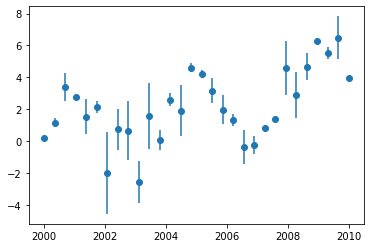

In [11]:
# dummy parameters
m1 = 0.4
b = -800.
A = 2.5
om = np.pi / 2

# dummy data
dummy_size = 30
year_list_dummy = np.linspace(2000, 2010, dummy_size)
pred_errs_dummy = 1.*np.random.randn(dummy_size)
temp_list_dummy = m1*year_list_dummy+b + A*np.sin(om*year_list_dummy) + pred_errs_dummy
timetable = pd.DataFrame({'year': year_list_dummy, 
                          'temperature': temp_list_dummy, 
                          'prediction_errors': pred_errs_dummy})

# plotting
plt.errorbar(year_list_dummy, temp_list_dummy, yerr=pred_errs_dummy, fmt='o')
plt.show()

/usr/local/lib/python3.9/site-packages/pymc3/sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, a, l]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 36 seconds.
There were 96 divergences after tuning. Increase `target_accept` or reparameterize.
There were 252 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6510086306546918, but should be close to 0.8. Try to increase the number of tuning steps.
There were 74 divergences after tuning. Increase `target_accept` or reparameterize.
There were 89 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/usr/local/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less use

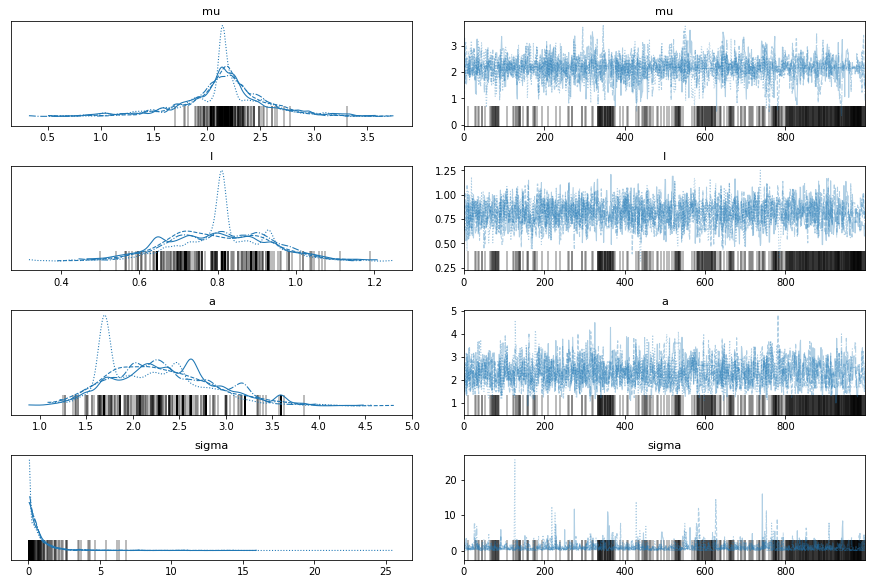

/usr/local/lib/python3.9/site-packages/pymc3/sampling.py:1688: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


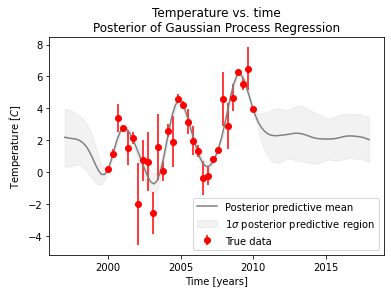

In [12]:
gpr_model = m.fit_GPR(timetable, num_forecast_years=5)

___
___